### 전이학습을 통해 모델을 하나 선택해서 cifar10을 불러와서 성능을 높여보기

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras import Input
from tensorflow.keras.layers import Dropout, BatchNormalization

### 데이터셋 불러오기

In [2]:
# 데이터셋 불러오기
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
print(X_train.shape, X_test.shape)


(50000, 32, 32, 3) (10000, 32, 32, 3)


### Data Split

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.3, random_state = 100)

In [4]:
X_train.shape

(35000, 32, 32, 3)

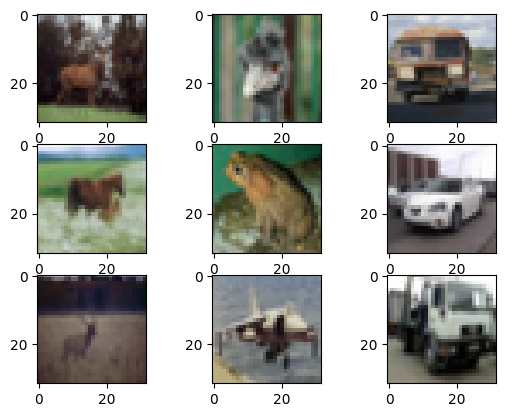

In [5]:
import matplotlib.pyplot as plt
import numpy as np

for temp in range(9):
    plt.subplot(3,3,temp+1)
    plt.imshow(X_train[temp])
    
#### 색상이 분류할때 영향을 가장 크게 미칠 수도 있다. 그러므로 색상을 정규화 시켜줘야한다.(그냥 작게 만들어 영향 미치니까)

### ResNet50 불러오기 

In [21]:
# ResNet50 불러오기 -> include_top = False로 바꾸는 것이 포인트
# base_model.trainable = False를 통해 사전학습된 resnet이 기존에 기억하던 weights를 손상주지 않기 위해 동결시킨다.
resnet = ResNet50(include_top=False, pooling = 'avg' , input_shape = (32,32 ,3), weights = 'imagenet')
# resnet.trainable = False

In [22]:
model = Sequential()
model.add(resnet)
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dense(10,activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_2 (Flatten)         (None, 2048)              0         
                                                                 
 dense_4 (Dense)             (None, 256)               524544    
                                                                 
 dense_5 (Dense)             (None, 10)                2570      
                                                                 
Total params: 24,114,826
Trainable params: 24,061,706
Non-trainable params: 53,120
_________________________________________________________________


### learning rate 수정

In [11]:
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
# 모델 컴파일
model.compile(optimizer=Adam(5e-5),loss='sparse_categorical_crossentropy',metrics=['acc'])

# early stopping 설정
es = EarlyStopping(monitor='val_loss', mode = 'min', patience = 3)

save = model.fit(X_train, y_train, epochs = 50, validation_data=(X_val, y_val), batch_size= 32, callbacks=[es])


Epoch 1/50
1094/1094 [==============================] - 37s 31ms/step - loss: 1.5932 - acc: 0.4665 - val_loss: 1.1544 - val_acc: 0.6217
Epoch 2/50
1094/1094 [==============================] - 33s 30ms/step - loss: 0.9775 - acc: 0.6636 - val_loss: 0.8836 - val_acc: 0.7007
Epoch 3/50
1094/1094 [==============================] - 33s 30ms/step - loss: 0.7551 - acc: 0.7400 - val_loss: 0.7981 - val_acc: 0.7289
Epoch 4/50
1094/1094 [==============================] - 33s 30ms/step - loss: 0.5990 - acc: 0.7940 - val_loss: 0.7478 - val_acc: 0.7511
Epoch 5/50
1094/1094 [==============================] - 33s 30ms/step - loss: 0.4744 - acc: 0.8355 - val_loss: 0.7433 - val_acc: 0.7595
Epoch 6/50
1094/1094 [==============================] - 33s 30ms/step - loss: 0.3732 - acc: 0.8719 - val_loss: 0.7446 - val_acc: 0.7720
Epoch 7/50
1094/1094 [==============================] - 33s 30ms/step - loss: 0.2910 - acc: 0.8984 - val_loss: 0.7529 - val_acc: 0.7773
Epoch 8/50
1094/1094 [==========================

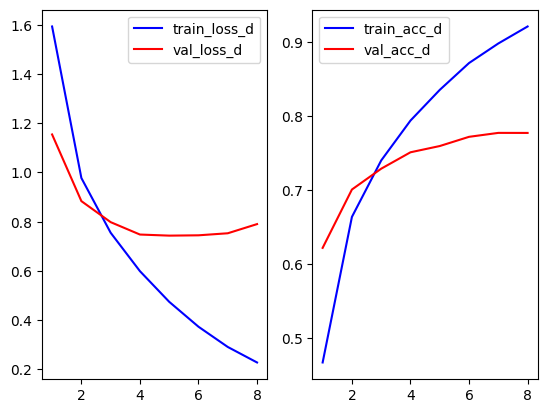

In [14]:
train_loss_d = save.history['loss']
val_loss_d = save.history['val_loss']
train_acc_d = save.history['acc']
val_acc_d = save.history['val_acc']

plt.subplot(1,2,1)
plt.plot(range(1,len(train_loss_d)+1),train_loss_d,color='blue',label='train_loss_d')
plt.plot(range(1,len(train_loss_d)+1),val_loss_d,color='red',label='val_loss_d')
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(1,len(train_acc_d)+1),train_acc_d,color='blue',label='train_acc_d')
plt.plot(range(1,len(train_acc_d)+1),val_acc_d,color='red',label='val_acc_d')
plt.legend()
plt.show()

In [15]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 3s 9ms/step - loss: 0.8196 - acc: 0.7727


[0.8196085095405579, 0.7727000117301941]

### save된 가중치 부터 다시 시작해보기

In [23]:
model.trainable = True		# resnet 모델 학습동결을 해제한다
for i in model.layers[:4]:
    i.trainable = False

In [25]:
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
# 모델 컴파일
model.compile(optimizer=Adam(5e-5),loss='sparse_categorical_crossentropy',metrics=['acc'])

# early stopping 설정
es = EarlyStopping(monitor='val_loss', mode = 'min', patience = 3)

# save2 = model.fit(X_train, y_train, epochs = save.epoch[-1], validation_data=(X_val, y_val), batch_size= 32, callbacks=[es])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_2 (Flatten)         (None, 2048)              0         
                                                                 
 dense_4 (Dense)             (None, 256)               524544    
                                                                 
 dense_5 (Dense)             (None, 10)                2570      
                                                                 
Total params: 24,114,826
Trainable params: 0
Non-trainable params: 24,114,826
_________________________________________________________________


In [26]:
save2 = model.fit(X_train, y_train, epochs = 20, validation_data=(X_val, y_val), batch_size= 32, callbacks=[es])


Epoch 1/20
1094/1094 [==============================] - 74s 13ms/step - loss: 4.3733 - acc: 0.0894 - val_loss: 4.4134 - val_acc: 0.0887
Epoch 2/20
1094/1094 [==============================] - 13s 12ms/step - loss: 4.3733 - acc: 0.0894 - val_loss: 4.4134 - val_acc: 0.0887
Epoch 3/20
1094/1094 [==============================] - 13s 12ms/step - loss: 4.3733 - acc: 0.0894 - val_loss: 4.4134 - val_acc: 0.0887
Epoch 4/20
1094/1094 [==============================] - 13s 12ms/step - loss: 4.3733 - acc: 0.0894 - val_loss: 4.4134 - val_acc: 0.0887


In [ ]:
train_loss_d = save2.history['loss']
val_loss_d = save2.history['val_loss']
train_acc_d = save2.history['acc']
val_acc_d = save2.history['val_acc']

plt.subplot(1,2,1)
plt.plot(range(1,len(train_loss_d)+1),train_loss_d,color='blue',label='train_loss_d')
plt.plot(range(1,len(train_loss_d)+1),val_loss_d,color='red',label='val_loss_d')
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(1,len(train_acc_d)+1),train_acc_d,color='blue',label='train_acc_d')
plt.plot(range(1,len(train_acc_d)+1),val_acc_d,color='red',label='val_acc_d')
plt.legend()
plt.show()